# Hybrid Node Clustering Approach for Graph-Based Anti-Money Laundering



==============================================================================
### Import Dependencies
==============================================================================

In [ ]:
######################################################
# Additional Lib
######################################################
import datetime
import os
from typing import Callable, Optional
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")
######################################################
# Data Visualizations
######################################################
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

######################################################
# Data Preprocessing
######################################################
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
######################################################
# Modelling
######################################################
from sklearn import preprocessing
import numpy as np
#import torch
#import torch_geometric.transforms as T
#from torch_geometric.loader import NeighborLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from tqdm.notebook import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

==============================================================================
### LOADING DATA
==============================================================================

In [ ]:
pd.set_option('display.max_columns', None)
path = '/content/hi_small_trxns.csv'
df = pd.read_csv(path)
df.head(10)
# df = df.head(500000)
df.head()

print("\n\n\n")
print("DATASET LENGTH")
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])





DATASET LENGTH
ROWS:  5078345
COLUMNS:  11


In [ ]:
###################################################################################################
# Data Visualization Function - Helpers
###################################################################################################

def format_title_output(text):
    return f"{'++' * 50}\n{text.upper()}\n{'++' * 50}\n"


#Null data with heatmap
def create_null_data_heatmap(
    title=None,
    rotate='horizontal',
    dataset=None
):
    try:
        plt.figure(figsize=(15,5))
        sns.heatmap(dataset.isnull(), cbar=False)
        plt.title(title, fontweight='bold')
        plt.xticks(rotation=rotate)
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)


#Null data with heatmap
def create_correlation_heatmap(
    title=None,
    dataset=None
):
    try:
        plt.figure(figsize=(15,8))
        correlation = dataset.corr()
        correlation = (correlation)
        sns.heatmap(correlation,
                    xticklabels=correlation.columns.values,
                    yticklabels=correlation.columns.values,
                    annot=True
        )
        plt.title(title, fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)

def create_boxplots(data, columns, ncols=2, figsize=(25, 6)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else axes
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


def create_histogram(data, column, figsize=(15, 4), color="g", kde=False):
    try:
        plt.figure(figsize=figsize)
        sns.histplot(data[column], kde=kde, color=color).set_title(f'{column[0]} Distribution', fontweight='bold')
        plt.title(f"{column[0]} Distribution", fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HISTOGRAM: ", error)
        print("**"*50)

###################################################################################################
# Data Preprocessing - Helpers
###################################################################################################
def detect_outliers(data, columns):
    outlier_info = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        max_outlier = outliers[col].max() if not outliers.empty else None

        outlier_info[col] = {
            "max_outlier_value": max_outlier,
            "number_of_outliers": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    return outlier_info

In [ ]:
# Check the dataset info
print(format_title_output("DATASET INFO"))
print(df.info())

print("\n\n\n")
print(format_title_output("DATASET LENGTH"))
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB
None




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET LENGTH
+++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
# rename the columns with lowercase and _ underscore if there is a space
print(format_title_output("DATASET NEW COLUMNS"))

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
for i,j in enumerate(df.columns):
    print(i, " : ", j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET NEW COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0  :  timestamp
1  :  from_bank
2  :  account
3  :  to_bank
4  :  account.1
5  :  amount_received
6  :  receiving_currency
7  :  amount_paid
8  :  payment_currency
9  :  payment_format
10  :  is_laundering


In [ ]:
# Convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get the min and max datetime
min_time = df['timestamp'].min()
max_time = df['timestamp'].max()

print("Min Datetime:", min_time)
print("Max Datetime:", max_time)

Min Datetime: 2022-09-01 00:00:00
Max Datetime: 2022-09-18 16:18:00


In [ ]:
amount_consistency = df.loc[~(df['amount_received'] == df['amount_paid'])]
ccy_consistency = df.loc[~(df['receiving_currency'] == df['payment_currency'])]

print(format_title_output("AMOUNT CONSISTENCY - CREDIT & DEBIT"))
print(amount_consistency.shape)

print(format_title_output("CURRENCY CONSISTENCY - CREDIT & DEBIT"))
print(ccy_consistency.shape)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
AMOUNT CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(72158, 11)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CURRENCY CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(72170, 11)


In [ ]:
#Check the currency

print(format_title_output("RECEIVED CURRENCY"))
print(df['receiving_currency'].unique())
print("\n\n")

print(format_title_output("PAYMENT CURRENCY"))
print(df['payment_currency'].unique())

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECEIVED CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee'
 'Mexican Peso' 'Yen' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee' 'Yen'
 'Mexican Peso' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']


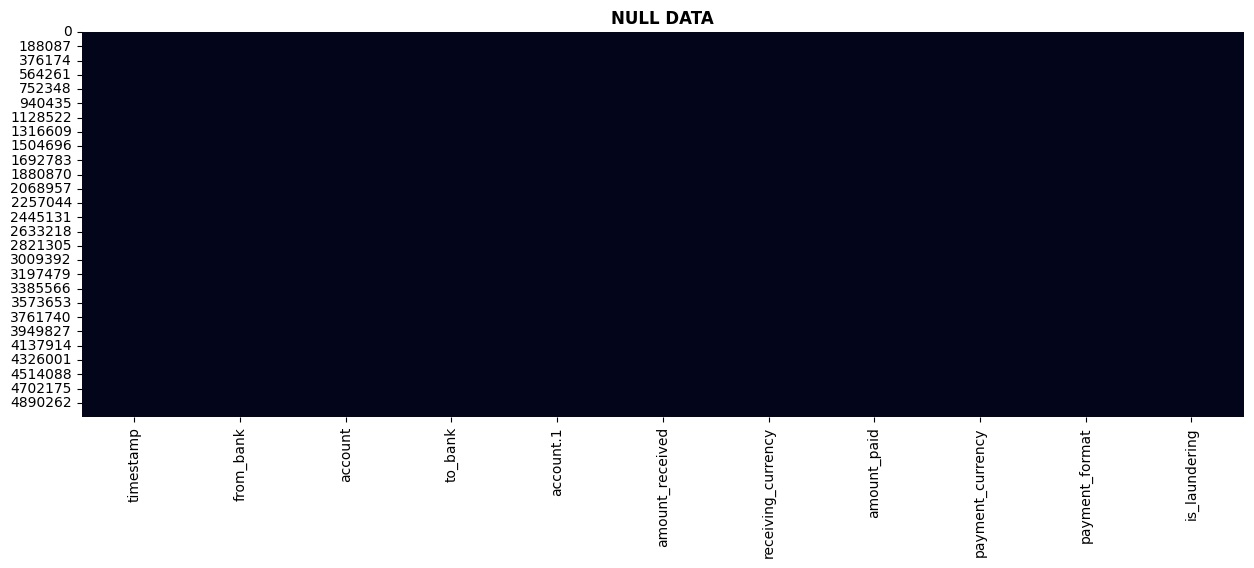

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NULL DATA NUMBER
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

timestamp             0
from_bank             0
account               0
to_bank               0
account.1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64


In [ ]:
create_null_data_heatmap("NULL DATA", 'vertical', df)
print(format_title_output("NULL DATA NUMBER"))
print(df.isnull().sum())

In [ ]:
negative_df = df[df['amount_paid'] < 0]
negative_df

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering


In [ ]:
df.head()
print(df.describe(include='all'))

                            timestamp     from_bank    account       to_bank  \
count                         5078345  5.078345e+06    5078345  5.078345e+06   
unique                            NaN           NaN     496995           NaN   
top                               NaN           NaN  100428660           NaN   
freq                              NaN           NaN     168672           NaN   
mean    2022-09-05 07:16:08.194274816  4.573057e+04        NaN  6.574456e+04   
min               2022-09-01 00:00:00  1.000000e+00        NaN  1.000000e+00   
25%               2022-09-02 04:32:00  1.190000e+02        NaN  4.259000e+03   
50%               2022-09-05 12:16:00  9.679000e+03        NaN  2.156800e+04   
75%               2022-09-08 03:13:00  2.862800e+04        NaN  1.223320e+05   
max               2022-09-18 16:18:00  3.563030e+05        NaN  3.562940e+05   
std                               NaN  8.176562e+04        NaN  8.409299e+04   

        account.1  amount_received rece

==============================================================================
### EDA
==============================================================================

In [ ]:
# Check the outlier for the amount of each transaction
# Function to convert to USD
# from forex_python.converter import CurrencyRates
exchange_rates = {
    'Australian Dollar': 0.62124,  # AUD
    'Bitcoin': 23000.0,            # BTC (example rate)
    'Brazil Real': 0.1980,         # BRL
    'Canadian Dollar': 0.6876,     # CAD
    'Euro': 1.0362,                # EUR
    'Mexican Peso': 0.04835,       # MXN
    'Ruble': 0.01636,              # RUB
    'Rupee': 0.01153,              # INR
    'Saudi Riyal': 0.2667,         # SAR
    'Shekel': 0.2840,              # ILS
    'Swiss Franc': 1.0989,         # CHF
    'UK Pound': 1.2401,            # GBP
    'US Dollar': 1.0,              # USD
    'Yen': 0.006443,               # JPY
    'Yuan': 0.1391                 # CNY
}

# Function to convert to USD
def convert_to_usd(currency, amount):
    if currency in exchange_rates:
        return amount * exchange_rates[currency]
    else:
        print(f"Exchange rate for {currency} not found.")
        return amount

def create_bar_plot(df, column_name, title=None):
    plt.figure(figsize=(20, 5))
    sns.countplot(x=column_name, data=df, order=df[column_name].value_counts().index, palette='Set2')
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_pie_plot(df, column_name, title=None):
    plt.figure(figsize=(8, 8))
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2', len(df[column_name].value_counts())))
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_kde_plot(df, column_name, title=None, color='g'):
    plt.figure(figsize=(15, 5))
    sns.kdeplot(df[column_name], shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

def create_kde_plot_with_log(df, column_name, title=None, color='r'):
    log_column = np.log1p(df[column_name])  # log(x+1) to avoid issues with zero values
    plt.figure(figsize=(15, 5))
    sns.kdeplot(log_column, shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper()))
    print(log_column.describe())

def create_histogram_with_bins(df, column_name, title=None, color='r', bins=20):
    plt.figure(figsize=(15, 5))
    sns.histplot(df[column_name], bins=bins, kde=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

    print(format_title_output(title.upper()))
    print(df[column_name].describe())

def create_transaction_line_plot(df, date_column, amount_column, title=None):
    df[date_column] = pd.to_datetime(df[date_column])
    daily_transactions = df.groupby(df[date_column].dt.date)[amount_column].sum().reset_index()
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=daily_transactions[date_column], y=daily_transactions[amount_column],
                 marker='o', color='b', linewidth=2, markersize=8, label='Transaction Amount')
    plt.title(title, fontweight='bold', color='#065164', fontsize=12)
    plt.xlabel('Date', fontsize=12, color='#065164')
    plt.ylabel('Total Transaction Amount', fontweight='bold', fontsize=12, color='#065164')
    plt.show()


In [ ]:
# Convert to the USD currency based on the exchange rate
df['usd_amount'] = df.apply(lambda row: convert_to_usd(row['payment_currency'], row['amount_paid']), axis=1)
none_us_dollar = df.loc[(df['payment_currency'] != 'US Dollar')]
none_us_dollar.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
1155,2022-09-01 00:16:00,220,8001C8C51,1420,8003093C1,0.025852,Bitcoin,0.025852,Bitcoin,Bitcoin,0,594.596000
1174,2022-09-01 00:22:00,1362,80030A870,11,80064C9B0,52.110000,Euro,52.110000,Euro,Credit Card,0,53.996382
1467,2022-09-01 00:15:00,1,80005C0A1,1588,8003AC471,0.016891,Bitcoin,0.016891,Bitcoin,Bitcoin,0,388.493000
3940,2022-09-01 00:08:00,513,8006538E1,1688,8006DD361,1.621978,Bitcoin,1.621978,Bitcoin,Bitcoin,0,37305.494000
6302,2022-09-01 00:19:00,1688,800646381,1674,800B1B1B1,0.045449,Bitcoin,0.045449,Bitcoin,Bitcoin,0,1045.327000


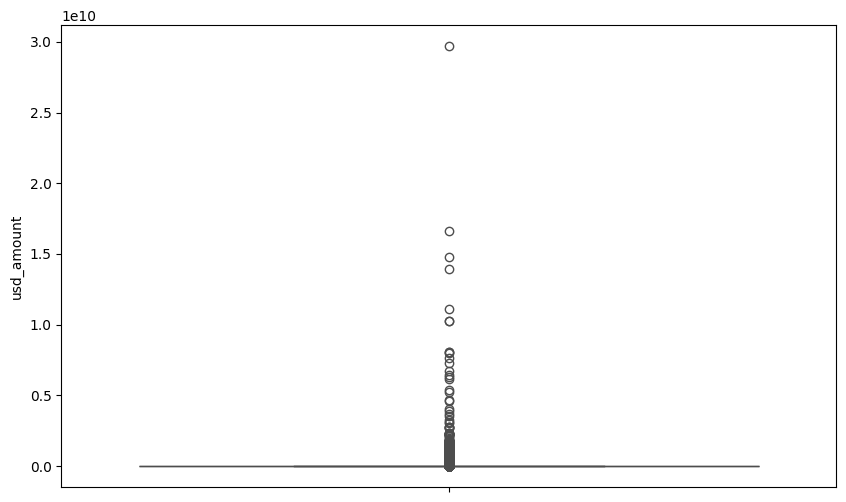

In [ ]:
#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df['usd_amount'] ,color='grey')
plt.show()

In [ ]:
outliers = detect_outliers(
    df,
    ['usd_amount'],
)
print(format_title_output("OUTLIERS DETECTION - AMOUNT RECEIVED & PAID"))
print(json.dumps(outliers, indent=4))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
OUTLIERS DETECTION - AMOUNT RECEIVED & PAID
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

{
    "usd_amount": {
        "max_outlier_value": 29692715211.5913,
        "number_of_outliers": 851433,
        "lower_bound": -7386.18,
        "upper_bound": 12717.916000000001
    }
}


In [ ]:
df_sorted = df.sort_values(by='usd_amount', ascending=False)
df_sorted.head(100)

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
3248641,2022-09-06 23:37:00,136334,80D81A180,235551,80D8816E0,1.499632e+11,Brazil Real,1.499632e+11,Brazil Real,ACH,0,2.969272e+10
780796,2022-09-01 14:03:00,1,801ABB8F0,2454,801ABEBC0,1.662061e+10,US Dollar,1.662061e+10,US Dollar,ACH,0,1.662061e+10
2809336,2022-09-06 01:28:00,24922,8096BB9C0,213,8096D4300,2.150069e+10,Canadian Dollar,2.150069e+10,Canadian Dollar,ACH,1,1.478388e+10
652515,2022-09-01 10:12:00,5365,80240ED60,410,80240F230,1.346399e+10,Euro,1.346399e+10,Euro,ACH,0,1.395139e+10
3437493,2022-09-07 08:30:00,112064,804C1CD70,7,804C41AB0,9.659333e+11,Rupee,9.659333e+11,Rupee,ACH,0,1.113721e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
60144,2022-09-01 00:04:00,1244,809656C80,4242,809657B10,1.337294e+09,US Dollar,1.337294e+09,US Dollar,ACH,0,1.337294e+09
7672,2022-09-01 00:28:00,1412,800CD5E00,1412,800CD6CA0,1.329258e+09,US Dollar,1.329258e+09,US Dollar,Cheque,0,1.329258e+09
1924795,2022-09-03 05:03:00,1467,803341D00,8595,803342EA0,1.318970e+09,US Dollar,1.318970e+09,US Dollar,Cheque,0,1.318970e+09
4816068,2022-09-09 21:40:00,29404,80AAF3A40,43818,8115402F0,4.625885e+09,Shekel,4.625885e+09,Shekel,Cheque,0,1.313751e+09


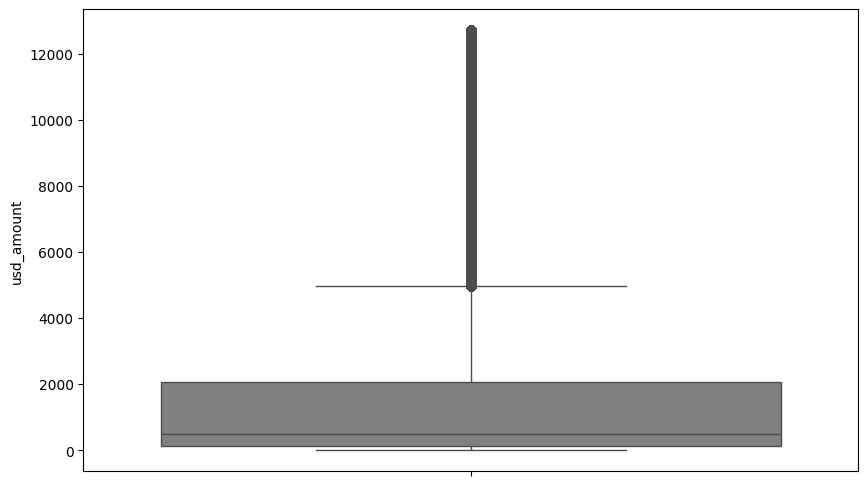

In [ ]:
#Remove outlierts
df_no_outliers = df[df['usd_amount'] <= outliers['usd_amount']['upper_bound']]
df_no_outliers = df_no_outliers[df_no_outliers['usd_amount'] > 0]

#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df_no_outliers['usd_amount'] ,color='grey')
plt.show()

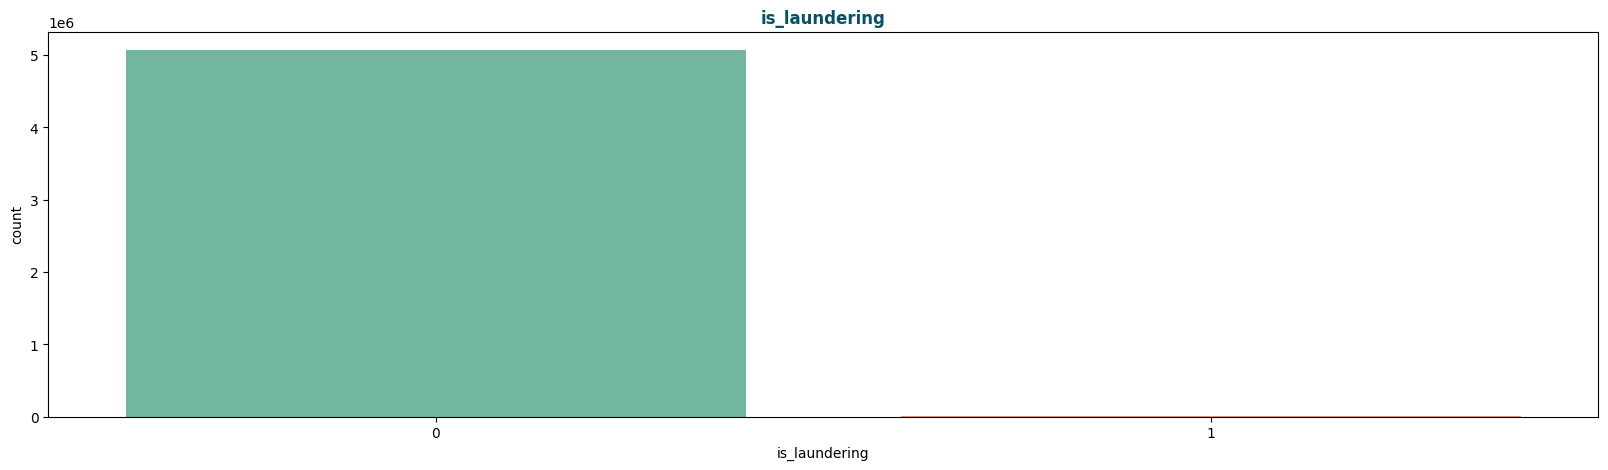

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS_LAUNDERING VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

is_laundering
0    5073168
1       5177
Name: count, dtype: int64


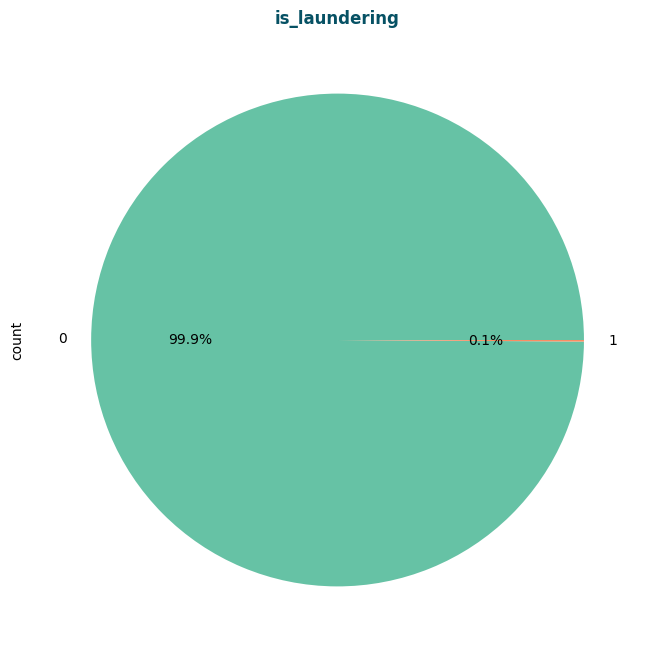

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS_LAUNDERING VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

is_laundering
0    5073168
1       5177
Name: count, dtype: int64


In [ ]:
create_bar_plot(
    df=df,
    column_name='is_laundering',
    title='is_laundering'
)


create_pie_plot(
    df=df,
    column_name='is_laundering',
    title='is_laundering'
)

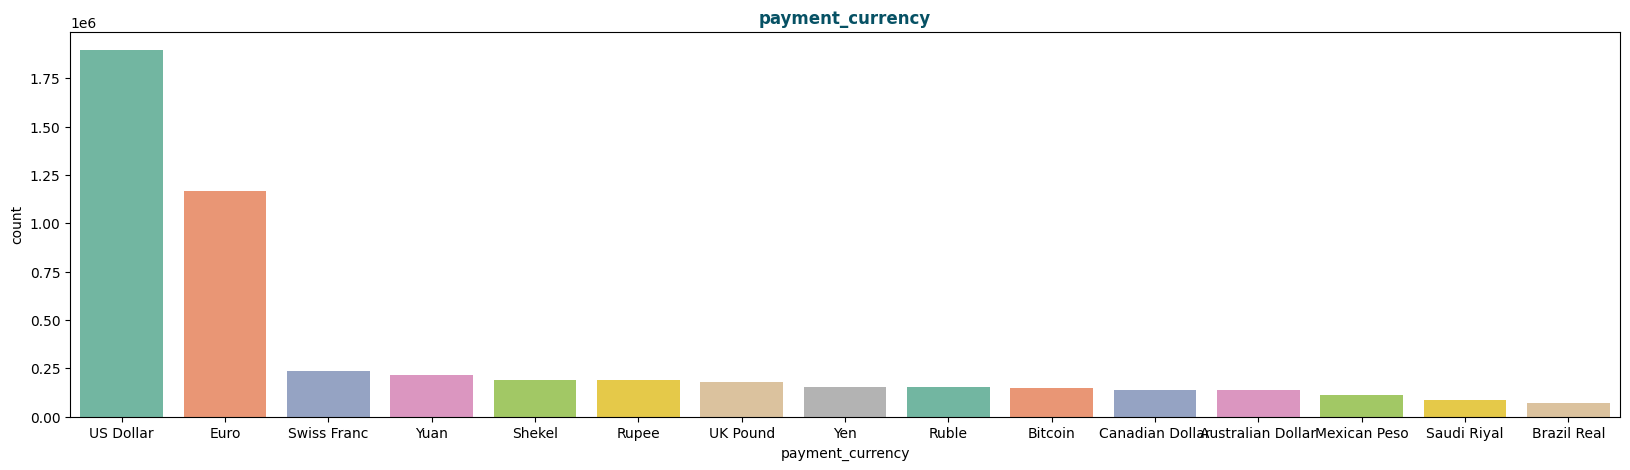

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_CURRENCY VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_currency
US Dollar            1895172
Euro                 1168297
Swiss Franc           234860
Yuan                  213752
Shekel                192184
Rupee                 190202
UK Pound              180738
Yen                   155209
Ruble                 155178
Bitcoin               146066
Canadian Dollar       140042
Australian Dollar     136769
Mexican Peso          110159
Saudi Riyal            89014
Brazil Real            70703
Name: count, dtype: int64


In [ ]:
create_bar_plot(
    df=df,
    column_name='payment_currency',
    title='payment_currency'
)

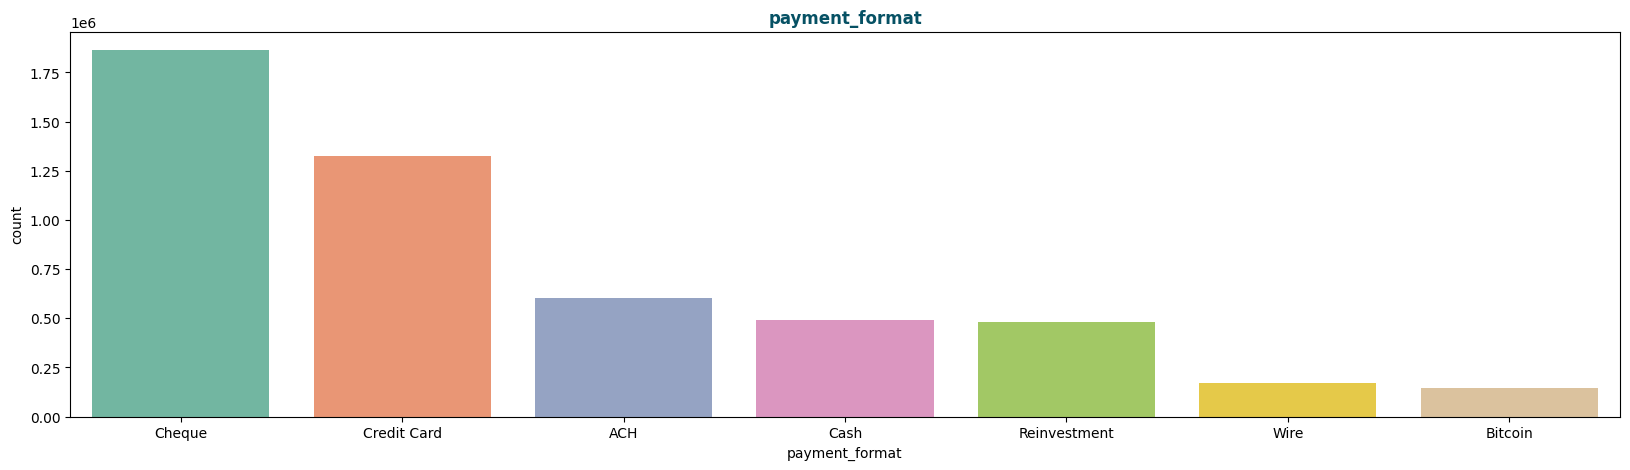

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Cheque          1864331
Credit Card     1323324
ACH              600797
Cash             490891
Reinvestment     481056
Wire             171855
Bitcoin          146091
Name: count, dtype: int64


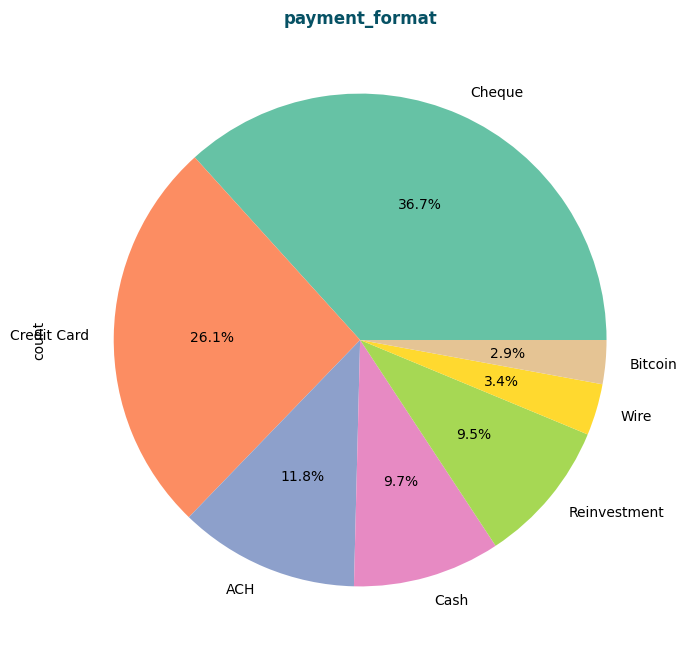

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Cheque          1864331
Credit Card     1323324
ACH              600797
Cash             490891
Reinvestment     481056
Wire             171855
Bitcoin          146091
Name: count, dtype: int64


In [ ]:
create_bar_plot(
    df=df,
    column_name='payment_format',
    title='payment_format'
)

create_pie_plot(
    df=df,
    column_name='payment_format',
    title='payment_format'
)

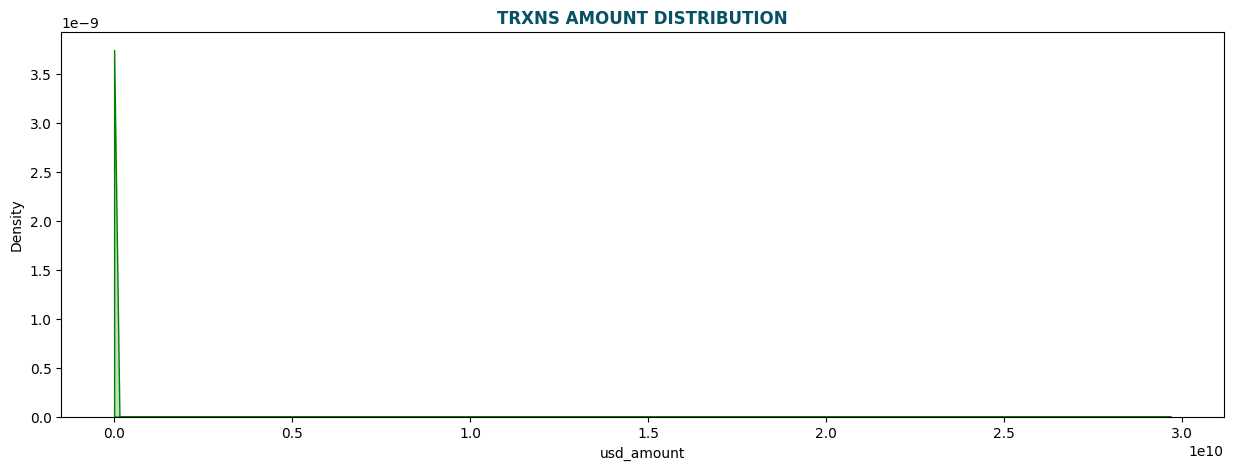

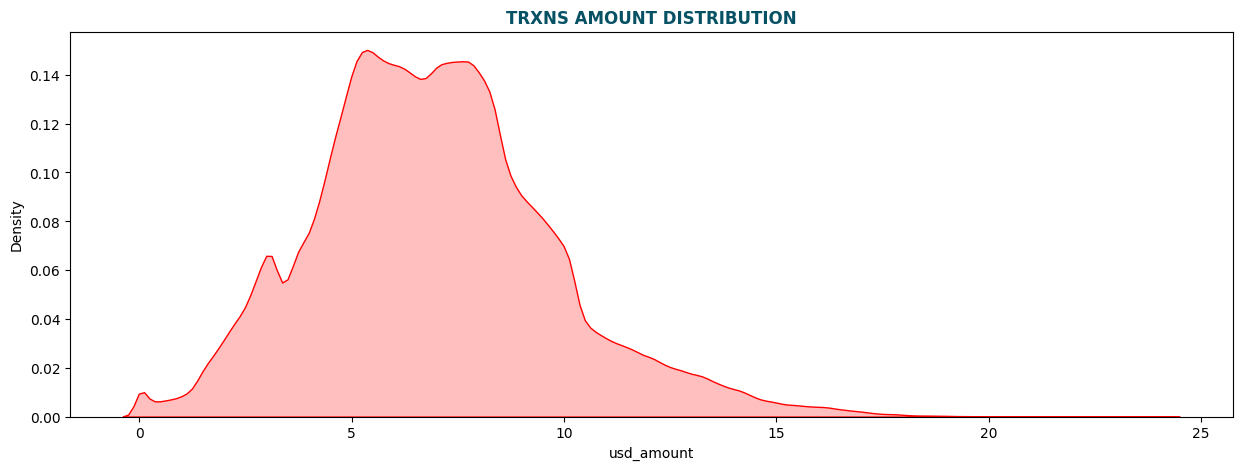

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TRXNS AMOUNT DISTRIBUTION
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

count    5.078345e+06
mean     6.932991e+00
std      2.843716e+00
min      6.442792e-05
25%      5.036017e+00
50%      6.765235e+00
75%      8.552537e+00
max      2.411417e+01
Name: usd_amount, dtype: float64


In [ ]:
create_kde_plot(df, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')
create_kde_plot_with_log(df, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')

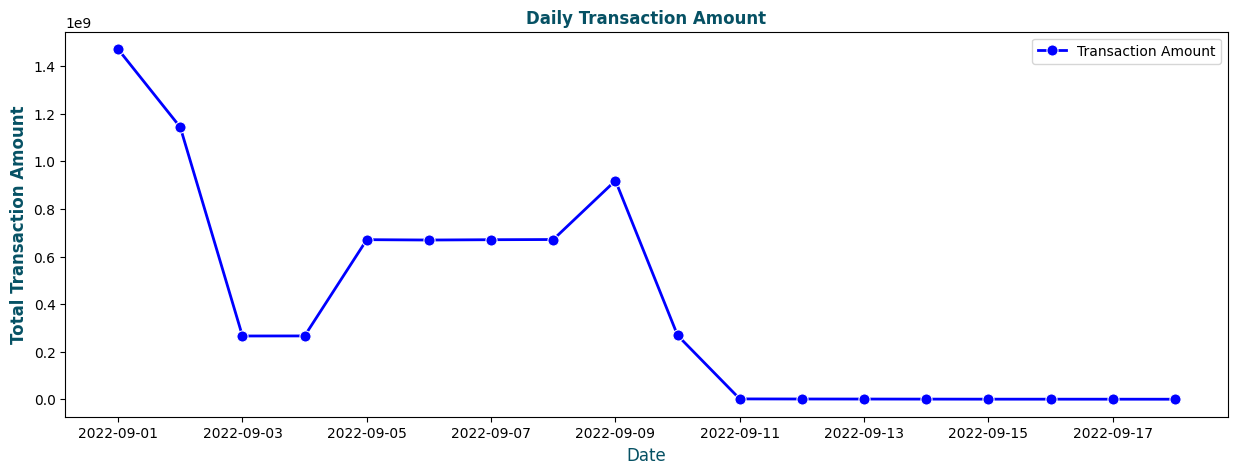

In [ ]:
create_transaction_line_plot(df_no_outliers, 'timestamp', 'usd_amount', 'Daily Transaction Amount')

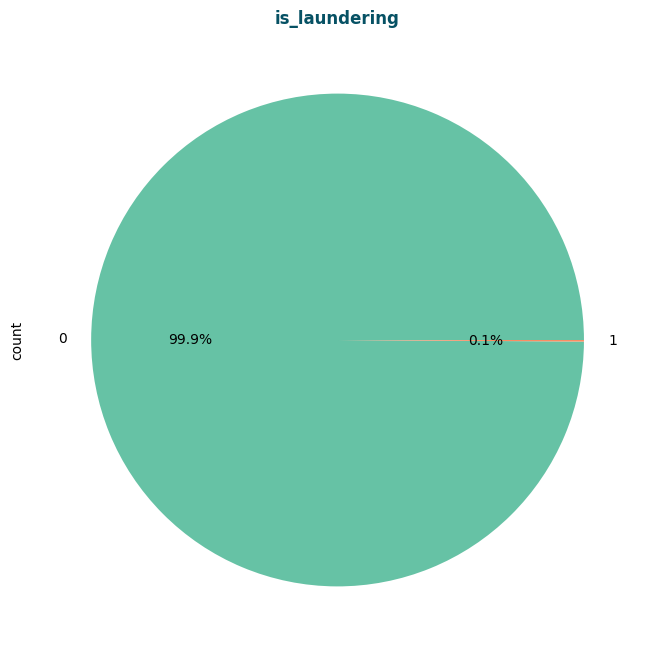

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS_LAUNDERING VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

is_laundering
0    5073168
1       5177
Name: count, dtype: int64


In [ ]:
create_pie_plot(
    df=df,
    column_name='is_laundering',
    title='is_laundering'
)

# IS LAUNDERING == 1 Analysis

In [ ]:
df_laundering = df[df['is_laundering'] == 1]
df_laundering.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
4742,2022-09-01 00:21:00,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1,389769.39
40621,2022-09-01 00:03:00,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1,29024.33
69152,2022-09-01 00:01:00,70,100428660,15980,80B39E7B0,792.92,US Dollar,792.92,US Dollar,Credit Card,1,792.92
85763,2022-09-01 00:03:00,70,100428660,113798,80DC756E0,13171425.53,US Dollar,13171425.53,US Dollar,Cheque,1,13171425.53
90684,2022-09-01 00:23:00,70,100428660,32375,80E480620,14288.83,US Dollar,14288.83,US Dollar,Cash,1,14288.83


In [ ]:
df_laundering_sorted = df_laundering.sort_values(by='usd_amount', ascending=False)
df_laundering_sorted.head(100)

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
2809336,2022-09-06 01:28:00,24922,8096BB9C0,213,8096D4300,2.150069e+10,Canadian Dollar,2.150069e+10,Canadian Dollar,ACH,1,1.478388e+10
2016473,2022-09-03 16:21:00,142183,80FB2BED0,42596,80FB2D130,2.486913e+09,Swiss Franc,2.486913e+09,Swiss Franc,ACH,1,2.732869e+09
557728,2022-09-01 07:25:00,4,806B9AF90,116781,806B9B6A0,8.485314e+10,Ruble,8.485314e+10,Ruble,ACH,1,1.388197e+09
2135966,2022-09-04 05:04:00,24922,809DC51F0,126191,809DC5380,1.240826e+09,Canadian Dollar,1.240826e+09,Canadian Dollar,ACH,1,8.531919e+08
825119,2022-09-01 15:26:00,14381,805C2AFB0,13029,805C2B8A0,6.641449e+10,Rupee,6.641449e+10,Rupee,ACH,1,7.657591e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
3805129,2022-09-08 13:00:00,19925,80C413DF0,23691,803BF05B0,4.100021e+06,Euro,4.100021e+06,Euro,ACH,1,4.248442e+06
3240081,2022-09-10 23:17:00,119,811C597B0,119,811C597B0,1.414481e+07,Saudi Riyal,1.414481e+07,Saudi Riyal,ACH,1,3.772420e+06
2176398,2022-09-06 05:52:00,9679,8039B1E10,13145,80145D800,3.510590e+06,US Dollar,3.510590e+06,US Dollar,ACH,1,3.510590e+06
535668,2022-09-03 21:58:00,12,800054B70,12,8002924E0,3.042619e+06,Euro,3.042619e+06,Euro,ACH,1,3.152762e+06


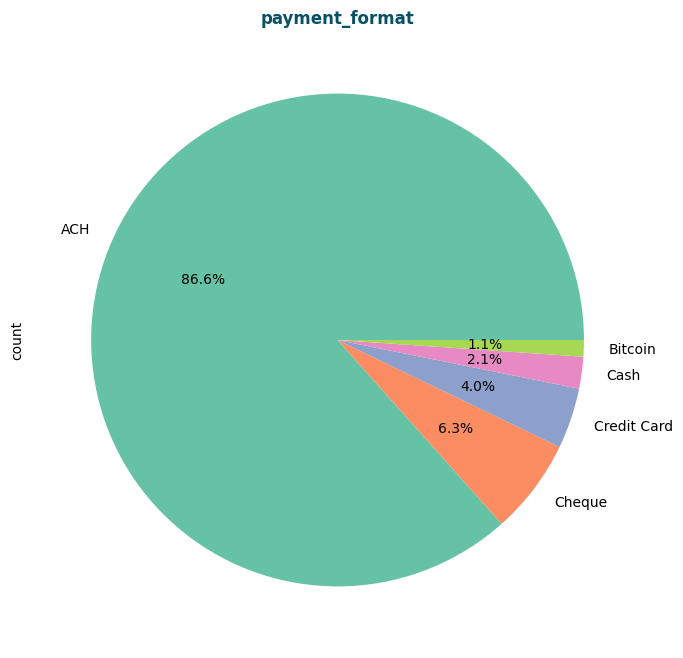

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
ACH            4483
Cheque          324
Credit Card     206
Cash            108
Bitcoin          56
Name: count, dtype: int64


In [ ]:
create_pie_plot(
    df=df_laundering,
    column_name='payment_format',
    title='payment_format'
)

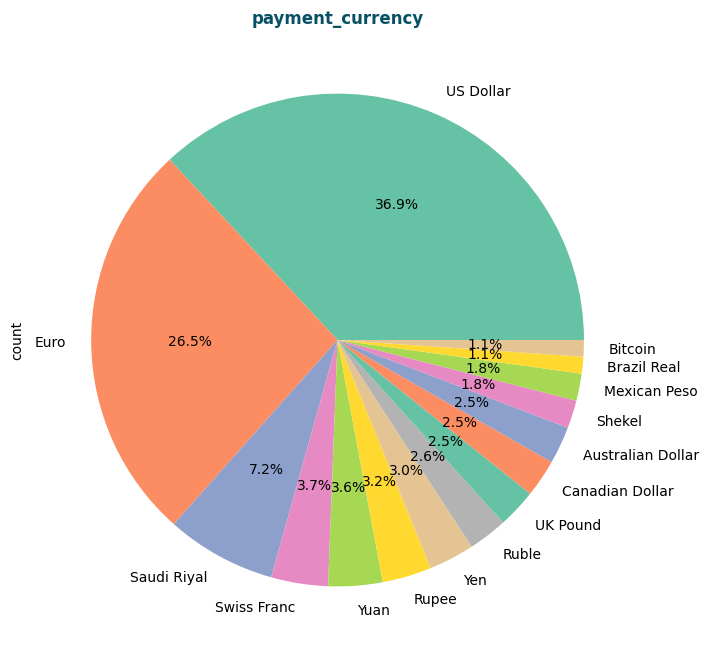

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_CURRENCY VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_currency
US Dollar            1912
Euro                 1372
Saudi Riyal           374
Swiss Franc           193
Yuan                  184
Rupee                 167
Yen                   155
Ruble                 133
UK Pound              132
Canadian Dollar       128
Australian Dollar     127
Shekel                 95
Mexican Peso           92
Brazil Real            57
Bitcoin                56
Name: count, dtype: int64


In [ ]:
create_pie_plot(
    df=df_laundering,
    column_name='payment_currency',
    title='payment_currency'
)

In [ ]:
print(df_laundering['usd_amount'].describe())

count    5.177000e+03
mean     4.849590e+06
std      2.109401e+08
min      3.419460e-01
25%      2.052960e+03
50%      5.714242e+03
75%      1.301507e+04
max      1.478388e+10
Name: usd_amount, dtype: float64


=== Transaction Breakdown by Currency and Amount Range ===

Currency: US Dollar
Total Transactions: 1912 (36.9% of total)
Average Transaction Amount: $632,000.62
Breakdown by Amount Range:
  Small ($0 to $2,634.97): 532 transactions
  Moderate ($2,634.97 to $8,667.21): 607 transactions
  Mid ($8,667.21 to $18,832.27): 589 transactions
  High ($18,832.27 to $36,140,000): 178 transactions
  Very High ($36,140,000+): 6 transactions
Largest Transaction: $275,426,029.85

Currency: Euro
Total Transactions: 1372 (26.5% of total)
Average Transaction Amount: $958,647.11
Breakdown by Amount Range:
  Small ($0 to $2,634.97): 441 transactions
  Moderate ($2,634.97 to $8,667.21): 418 transactions
  Mid ($8,667.21 to $18,832.27): 436 transactions
  High ($18,832.27 to $36,140,000): 70 transactions
  Very High ($36,140,000+): 7 transactions
Largest Transaction: $423,532,808.62

Currency: Saudi Riyal
Total Transactions: 374 (7.2% of total)
Average Transaction Amount: $2,170,930.03
Breakdown by Amount 

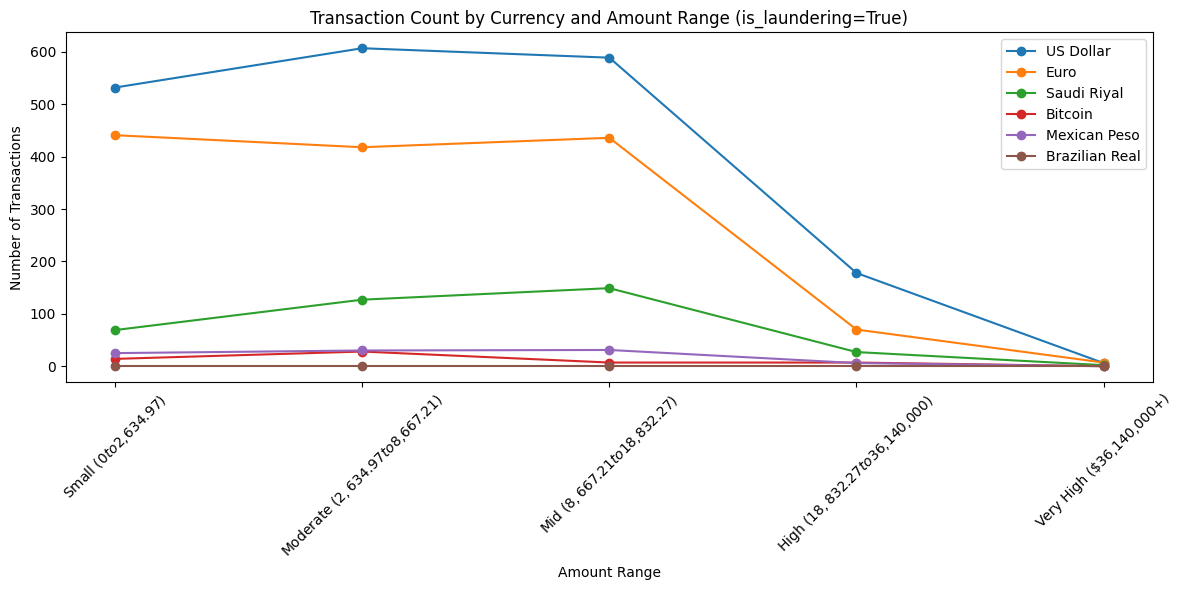

In [ ]:
# Define transaction amount ranges based on the quartiles and mean
ranges = {
    'Small ($0 to $2,634.97)': (0, 2634.97),
    'Moderate ($2,634.97 to $8,667.21)': (2634.97, 8667.21),
    'Mid ($8,667.21 to $18,832.27)': (8667.21, 18832.27),
    'High ($18,832.27 to $36,140,000)': (18832.27, 36140000),
    'Very High ($36,140,000+)': (36140000, float('inf'))
}

# Currencies to focus on
focus_currencies = ['US Dollar', 'Euro', 'Saudi Riyal', 'Bitcoin', 'Mexican Peso', 'Brazilian Real']

# Function to categorize amounts into ranges
def categorize_amount(amount):
    for range_name, (low, high) in ranges.items():
        if low <= amount < high:
            return range_name
    return 'Very High ($36,140,000+)'

# Add a column for amount ranges
df_laundering['amount_range'] = df_laundering['usd_amount'].apply(categorize_amount)

# Analyze transactions by currency and amount range
print("=== Transaction Breakdown by Currency and Amount Range ===")
for currency in focus_currencies:
    print(f"\nCurrency: {currency}")
    currency_df = df_laundering[df_laundering['payment_currency'] == currency]

    # Total count and percentage of transactions
    total_count = len(currency_df)
    total_transactions = len(df_laundering)
    percentage = (total_count / total_transactions) * 100
    print(f"Total Transactions: {total_count} ({percentage:.1f}% of total)")

    # Average transaction amount
    avg_amount = currency_df['usd_amount'].mean()
    print(f"Average Transaction Amount: ${avg_amount:,.2f}")

    # Breakdown by amount range
    range_breakdown = currency_df.groupby('amount_range').size().reindex(ranges.keys(), fill_value=0)
    print("Breakdown by Amount Range:")
    for range_name, count in range_breakdown.items():
        print(f"  {range_name}: {count} transactions")

    # Largest transaction in this currency
    max_amount = currency_df['usd_amount'].max()
    print(f"Largest Transaction: ${max_amount:,.2f}")

# Visualize the distribution of transactions by currency and amount range
plt.figure(figsize=(12, 6))
for currency in focus_currencies:
    currency_df = df_laundering[df_laundering['payment_currency'] == currency]
    range_counts = currency_df.groupby('amount_range').size().reindex(ranges.keys(), fill_value=0)
    plt.plot(range_counts.index, range_counts.values, marker='o', label=currency)

plt.title('Transaction Count by Currency and Amount Range (is_laundering=True)')
plt.xlabel('Amount Range')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
max_amount_row = df_laundering[df_laundering['usd_amount'] == df_laundering['usd_amount'].max()]

# Display the row
print("Row with Maximum Amount:")
print(max_amount_row)

Row with Maximum Amount:
                  timestamp  from_bank    account  to_bank  account.1  \
2809336 2022-09-06 01:28:00      24922  8096BB9C0      213  8096D4300   

         amount_received receiving_currency   amount_paid payment_currency  \
2809336     2.150069e+10    Canadian Dollar  2.150069e+10  Canadian Dollar   

        payment_format  is_laundering    usd_amount              amount_range  
2809336            ACH              1  1.478388e+10  Very High ($36,140,000+)  


In [ ]:
print(df_laundering.amount_range.value_counts())

amount_range
Moderate ($2,634.97 to $8,667.21)    1624
Mid ($8,667.21 to $18,832.27)        1606
Small ($0 to $2,634.97)              1543
High ($18,832.27 to $36,140,000)      378
Very High ($36,140,000+)               26
Name: count, dtype: int64
